# Secure Federated Linear Regression – Multi‑Round Convergence
*Protocol v3 – 15 Rounds, 10 Clients, 80 % Participation*

This notebook shows how test **MSE** evolves across 15 communication rounds for five datasets.

## 1. Imports & helper utilities

In [ ]:
import numpy as np, matplotlib.pyplot as plt, warnings
from sklearn.datasets import fetch_california_housing, load_diabetes, fetch_openml
from sklearn.metrics import mean_squared_error

SEED = 42
np.random.seed(SEED)

In [1]:
def add_intercept(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])

def split_random(X, y, seed=SEED, test_size=0.1):
    rng = np.random.RandomState(seed)

    idx = rng.permutation(len(y))
    split = int((1 - test_size) * len(y))

    return X[idx[:split]], X[idx[split:]], y[idx[:split]], y[idx[split:]]

def random_clients(X, y, n=10, seed=SEED):
    idx = np.random.RandomState(seed).permutation(len(y))
    chunks = np.array_split(idx, n)

    clients=[]
    for i, ch in enumerate(chunks):
        X_train, X_test, y_train, y_test = split_random(X[ch], y[ch], seed=i)
        clients.append({
            'X_train': add_intercept(X_train),
            'y_train': y_train,
            'X_test': add_intercept(X_test),
            'y_test': y_test
        })
    return clients


## 2. Dataset builders

In [3]:
def clients_synth(seed=0):
    rng=np.random.default_rng(seed)

    w=rng.normal(size=7)
    clients=[]
    for i in range(10):
        m = rng.integers(800,2000)

        X = rng.normal(loc=5*i, size=(m, 7))
        y = X @ w + rng.normal(scale=1.0, size=m)

        Xtr, Xte, ytr, yte = split_random(X, y, seed=i)
        clients.append({
            'X_train': add_intercept(Xtr),
            'y_train': ytr,
            'X_test': add_intercept(Xte),
            'y_test': yte
        })

    return clients

def clients_california(seed=SEED):
    d = fetch_california_housing()
    X, y = d.data, d.target

    lat_sorted = np.argsort(X[:, 6])
    slices = np.array_split(lat_sorted, 10)

    out=[]
    for i, sl in enumerate(slices):
        Xtr, Xte, ytr, yte = split_random(X[sl], y[sl], seed=i)
        out.append({
            'X_train': add_intercept(Xtr),
            'y_train': ytr,
            'X_test': add_intercept(Xte),
            'y_test': yte
        })

    return out

def clients_diabetes(seed=SEED):
    d=load_diabetes()
    return random_clients(d.data, d.target, 10, seed)

def clients_ames(seed=SEED):
    df = fetch_openml('house_prices', as_frame=True, parser='pandas').frame
    df = df.select_dtypes(include=['number']).dropna()

    y = df['SalePrice'].astype(float).values
    X = df.drop(columns=['SalePrice']).to_numpy(dtype=float)

    return random_clients(X, y, 10, seed)

def clients_wine(seed=SEED):
    df = fetch_openml('wine-quality-red', as_frame=True, parser='pandas').frame

    y = df['class'].astype(float).values
    X = df.drop(columns=['class']).astype(float).to_numpy()

    return random_clients(X, y, 10, seed)


## 3  Secure protocol implementation

In [4]:
def secure_single_round(clients, beta=(-0.1, 0.1), seed=SEED):
    rng = np.random.default_rng(seed)

    n = clients[0]['X_train'].shape[1] - 1

    while True:
        W = rng.normal(size=(n+2,n+2))
        W[-1, :] = 1.0
        if np.linalg.matrix_rank(W) == n + 2:
            break

    L = np.zeros((n+1, n+2))
    for c in clients:
        X, y = c['X_train'],c['y_train']
        Y = np.tile(y.reshape(-1, 1), (1, n+2))

        Li = X.T @ (X @ W[:-1,:] - Y)

        beta_val = rng.uniform(*beta)

        L += (1-beta_val) * Li

    C = L @ np.linalg.inv(W)
    A, b = C[:, :-1], C[:, -1]

    return -np.linalg.solve(A, b)

def mse_global(w,clients):
    X = np.vstack([c['X_test'] for c in clients])
    y = np.hstack([c['y_test'] for c in clients])

    return mean_squared_error(y, X @ w)


## 4. Run multi-round experiment per dataset

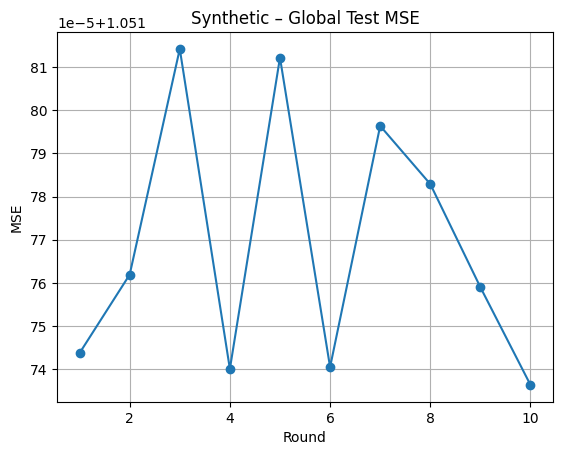

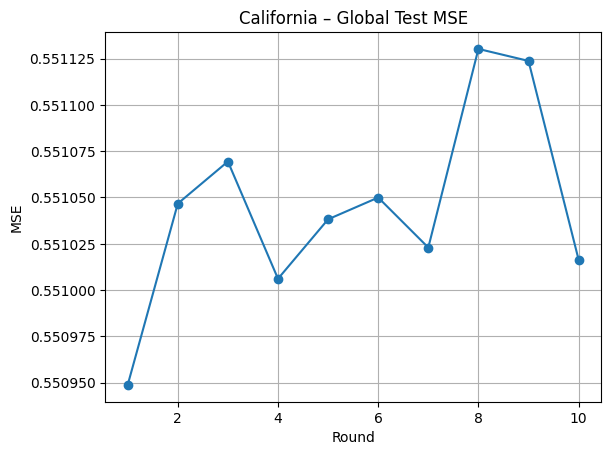

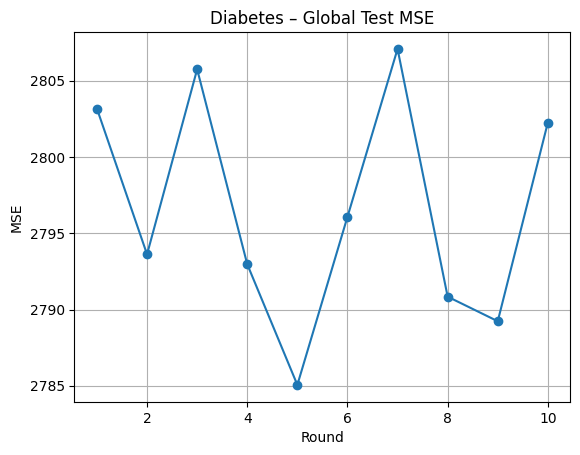

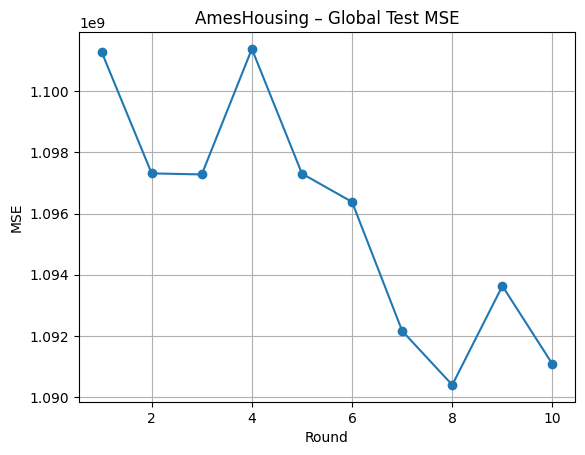

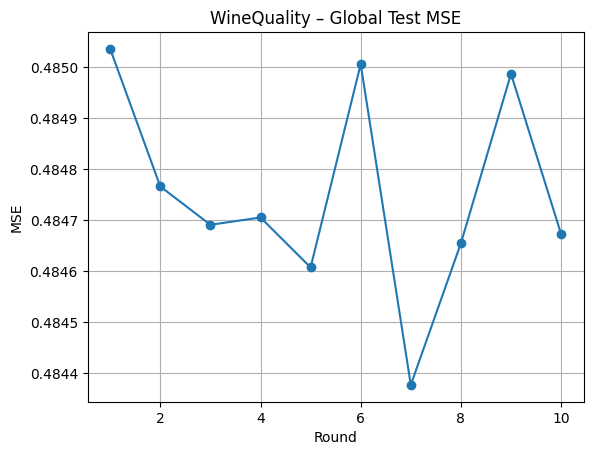

In [8]:
datasets = {'Synthetic': clients_synth(),
            'California': clients_california(),
            'Diabetes': clients_diabetes(),
            'AmesHousing': clients_ames(),
            'WineQuality': clients_wine()
}

PARTICIPATION = 1
ROUNDS = 10
rng = np.random.default_rng(0)

for name, base in datasets.items():
    history = []
    for r in range(ROUNDS):
        idx = rng.choice(len(base), size=int(PARTICIPATION * len(base)), replace=False)
        subset = [base[i] for i in idx]

        w = secure_single_round(subset, beta=(-0.05, 0.05), seed=r)

        history.append(mse_global(w, base))

    plt.figure()
    plt.plot(range(1, ROUNDS+1), history, marker='o')
    plt.title(f'{name} – Global Test MSE')
    plt.xlabel('Round')
    plt.ylabel('MSE')
    plt.grid(True)
    plt.show()
